# Learning from Data

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


## Paper Exercise

Let us start with a simple exercise in classifying credit risk. 

We have the following features in our dataset. 
- Risk - ordinal (label)
- Income - continuous
- Credit History - ordinal


We want to find out the rules that would help us classify the three risk type - This is a paper and pen exercise first!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv("data/creditRisk.csv")
df.head()

,Income,Credit History,Risk
0,0,Unknown,High
1,0,Bad,High
2,0,Good,High
3,14000,Unknown,High
4,14000,Bad,High


In [4]:
df.dtypes

Income             int64
Credit History    object
Risk              object
dtype: object

## Plotting the Data

In [6]:
import seaborn as sns

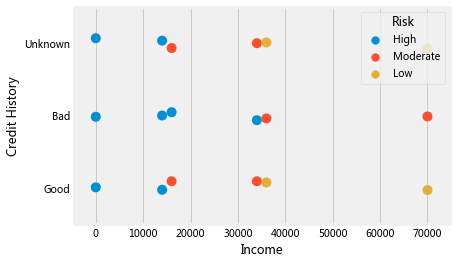

In [7]:
sns.stripplot(data = df, x = "Income", y = "Credit History", hue = "Risk", size = 10);

## Preparing Data

We have one ordinal variable (Risk) and one nominal variable (Credit History)

Lets use a dictionary for encoding nominal variable

In [8]:
df.Risk.unique()

array(['High', 'Moderate', 'Low'], dtype=object)

In [9]:
Risk_mapping = {
       'High': 2,
       'Moderate': 1,
       'Low': 0}

In [10]:
df['Risk'] = df['Risk'].map(Risk_mapping)

In [11]:
df['Credit History'].unique()

array(['Unknown', 'Bad', 'Good'], dtype=object)

In [12]:
Credit_mapping = {
        'Unknown': 0,
        'Bad': -1,
        'Good': 1}

In [13]:
df['Credit History'] = df['Credit History'].map(Credit_mapping)

In [14]:
df.head()

,Income,Credit History,Risk
0,0,0,2
1,0,-1,2
2,0,1,2
3,14000,0,2
4,14000,-1,2


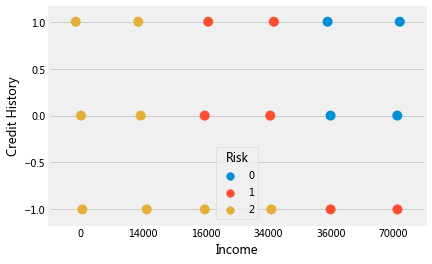

In [15]:
sns.stripplot(data = df, x = "Income", y = "Credit History", hue = "Risk", size = 10);

## Decision Tree Classifier

In [16]:
data = df.iloc[:,0:2]
target = df.iloc[:,2:3]

In [17]:
from sklearn import tree

In [18]:
clf = tree.DecisionTreeClassifier()

In [19]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
clf = clf.fit(data, target)

## Visualise the Tree

In [22]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 1.3MB/s ta 0:00:01
  Stored in directory: /Users/datalab/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [23]:
import pydotplus 
from IPython.display import Image

In [24]:
data.columns

Index(['Income', 'Credit History'], dtype='object')

In [34]:
target.columns

Index(['Risk'], dtype='object')

In [26]:
dot_data = tree.export_graphviz(clf, out_file='tree.dot', feature_names=data.columns,
                                class_names=['Low', 'Moderate', 'High'], filled=True, 
                                rounded=True, special_characters=True)

In [27]:
graph = pydotplus.graph_from_dot_file('tree.dot')  

> brew install graphviz


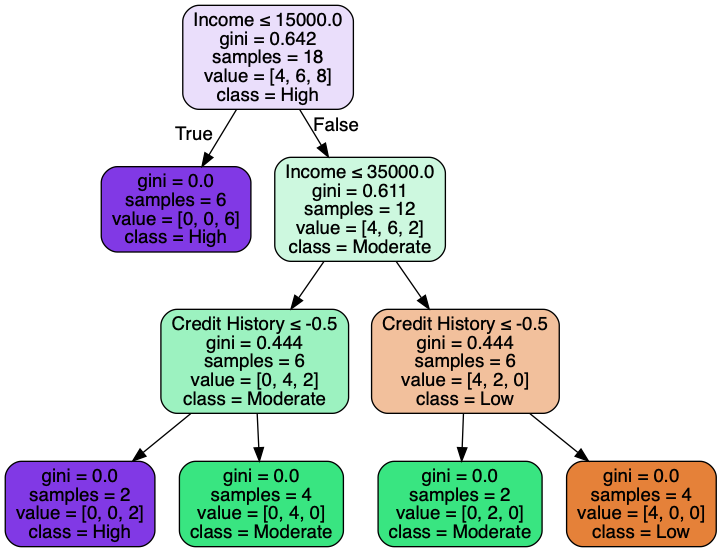

In [29]:
Image(graph.create_png()) 

## Understanding how the Decision Tree works

**Terminology**
- Each root node represents a single input variable (x) and a split point on that variable.
- The leaf nodes of the tree contain an output variable (y) which is used to make a prediction.

**Growing the tree**

- The first choice we have is how many branches we split the trees. And we choose Binary Tree because otherwise it will explode due to combinatorial explosion. So **BINARY TREES** is a practical consideration.
- The second decision is to choose which variable and where to split it. We need to have an objective function to do this



One objective function is to maximize the information gain (IG) at each split:

$$ IG(D_p,f)= I(D_p) - \frac{N_{right}}{N} I(D_{right}) - \frac{N_{left}}{N} I(D_{left}) $$

where: 
- f is the feature to perform the split
- $D_p$, $D_{left}$, and $D_{right}$ are the datasets of the parent, left and right child node, respectively
- I is the impurity measure
- N is the total number of samples
- $N_{left}$ and $N_{right}$ is the number of samples in the left and right child node. 

Now we need to first define an Impurity measure. The three popular impurity measures are:
    - Gini Impurity
    - Entropy
    - Classification Error
    
Gini Impurity and Entropy lead to similiar results when growing the tree, while Classification error is not as useful for growing the tree (but for pruning the tree) - See example here http://sebastianraschka.com/faq/docs/decision-tree-binary.html

Lets understand Gini Impurity a little better. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset,  Gini impurity can be computed by summing the probability $t_{i} $ of an item with label $i$ being chosen times the probability $ 1-t_{i}$ of a mistake in categorizing that item.

$$ I_{G}(f)=\sum _{i=1}^{J}t_{i}(1-t_{i})=\sum _{i=1}^{J}(t_{i}-{t_{i}}^{2})=\sum _{i=1}^{J}t_{i}-\sum _{i=1}^{J}{t_{i}}^{2}=1-\sum _{i=1}^{J}{t_{i}}^{2} $$

#### Lets calculate the Gini for the overall data set:

Low - 4, Moderate - 6, High - 8 and total observations are 18 

$$ I_G(t) = 1 - \left(\frac{6}{18}\right)^2 - \left(\frac{4}{18}\right)^2 - \left(\frac{8}{18}\right)^2 = 1 - \frac{116}{256} = 0.642 $$

scikit-learn uses an optimized CART algorithm, which will use a greedy approach.  A greedy approach is used to divide the space called recursive binary splitting. This is a numerical procedure where all the values are lined up and different split points are tried and tested using a objective cost function. The split with the best cost (lowest cost because we minimize cost) is selected.

Another way to think of this is that a learned binary tree is actually a partitioning of the input space. You can think of each input variable as a dimension on an p-dimensional space. The decision tree split this up into rectangles (when p=2 input variables) or some kind of hyper-rectangles with more inputs. 

We can draw these partitions for our dataset

In [35]:
x_min, x_max = data.iloc[:, 0].min() - 2000, data.iloc[:, 0].max() + 2000
y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/100), np.arange(y_min, y_max, (y_max - y_min)/100))

In [37]:
target

,Risk
0,2
1,2
2,2
3,2
4,2
5,2
6,1
7,2
8,1
9,1


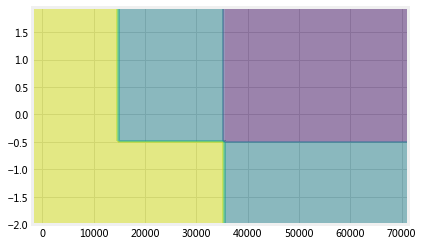

In [38]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha = 0.5)
#plt.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = target, s = 100, cmap=plt.cm.magma);

ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c =     Risk
0      2
1      2
2      2
3      2
4      2
5      2
6      1
7      2
8      1
9      1
10     2
11     1
12     0
13     1
14     0
15     0
16     1
17     0.

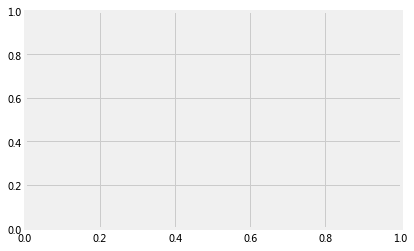

In [40]:
plt.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = target, s = 100, cmap=plt.cm.magma)

**Stop growing the tree**

- The obvious point to stop growing the tree is when the Gini Impurity = 0, that is there is only one label left in a node
- Another option is to define a max_depth of the tree, though this may lead to suboptimal trees.
- The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.